# 1.2 - Supplementary results

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import lifelines

In [2]:
GENESET = "Hallmarks-nostd"

logrank_test = pd.read_csv(f"../data/{GENESET}/logrank-scores-test-statistic.tsv", sep="\t", index_col=[0]).fillna(0)
logrank_pval = pd.read_csv(f"../data/{GENESET}/logrank-scores-p-value.tsv", sep="\t", index_col=[0]).fillna(1)
rmst_scores = pd.read_csv(f"../data/{GENESET}/rmst-difference-scores.tsv", sep="\t", index_col=[0]).fillna(0)

In [3]:
TIME_LIMIT_PERCENTILE = 75

# normalize RMST scores
for tcga in rmst_scores.columns:

    clinical = pd.read_csv(f"../tcga-data/data/raw/TCGA-{tcga}-survival.csv").dropna()
    time_limit = np.percentile(clinical["time"].values, TIME_LIMIT_PERCENTILE)
    rmst_scores[tcga] = rmst_scores[tcga]/time_limit

## General comparison on datasets

In [4]:
TCGA_DATASETS = sorted([
    "LGG", "KIRC", "SKCM", "LIHC", "CESC", "SARC",
    "PAAD", "LAML", "STAD", "BLCA", "LUAD",
    "HNSC"])
TCGA_DATASETS

['BLCA',
 'CESC',
 'HNSC',
 'KIRC',
 'LAML',
 'LGG',
 'LIHC',
 'LUAD',
 'PAAD',
 'SARC',
 'SKCM',
 'STAD']

## 1 - Appendix: Table of all highest hits for each dataset

In [28]:
## Table of results for Latex
tcga_grouped = {}

for tcga in logrank_pval.columns:
    x = pd.concat((
        pd.Series(ss.false_discovery_control(logrank_pval[tcga].values), index=logrank_pval.index),
        logrank_test[tcga],
        np.abs(rmst_scores[tcga])
    ), axis=1)
    x.columns = ["p-value", "logrank", "rmst"]

    tcga_grouped[tcga] = x

results = []
for tcga in tcga_grouped.keys():
    results += [(tcga, tcga_grouped[tcga].min().loc["p-value"])]

projects = [x[0] for x in sorted(results, key=lambda x: x[1], reverse=False)]
for p in projects:
    if p not in TCGA_DATASETS:
        continue
    x = tcga_grouped[p].sort_values(by=["logrank"], ascending=False).iloc[0]
    rmst_rank = 50-np.argsort(np.argsort(np.abs(tcga_grouped[p].sort_values(by=["logrank"], ascending=False))["rmst"]))[0]
    
    underscore, backslash_underscore = "_", "\_"
    backslash = "\\"
    brakets = "{}"
    print(f"{p} & {x.name.split('HALLMARK_')[1].replace(underscore, backslash_underscore)} & {x.loc['logrank']:.1f} & {x.loc['p-value']:.1e} & {rmst_rank} & {'+' if rmst_scores[p][x.name] > 0 else '-'} &{backslash}cite{brakets} {backslash}{backslash}")

LGG & EPITHELIAL\_MESENCHYMAL\_TRANSITION & 33.9 & 3.0e-07 & 1 & - &\cite{} \\
KIRC & FATTY\_ACID\_METABOLISM & 32.5 & 3.5e-07 & 4 & + &\cite{} \\
SKCM & INTERFERON\_ALPHA\_RESPONSE & 30.7 & 1.5e-06 & 1 & + &\cite{} \\
LIHC & SPERMATOGENESIS & 25.5 & 2.2e-05 & 1 & - &\cite{} \\
LAML & FATTY\_ACID\_METABOLISM & 24.5 & 3.6e-05 & 1 & - &\cite{} \\
STAD & ANGIOGENESIS & 20.2 & 3.6e-04 & 1 & - &\cite{} \\
LUAD & GLYCOLYSIS & 19.7 & 4.5e-04 & 2 & - &\cite{} \\
CESC & UNFOLDED\_PROTEIN\_RESPONSE & 18.0 & 1.1e-03 & 1 & - &\cite{} \\
HNSC & UNFOLDED\_PROTEIN\_RESPONSE & 17.1 & 1.7e-03 & 1 & - &\cite{} \\
BLCA & HEDGEHOG\_SIGNALING & 14.9 & 5.6e-03 & 3 & - &\cite{} \\
PAAD & TGF\_BETA\_SIGNALING & 14.1 & 6.0e-03 & 5 & - &\cite{} \\
SARC & MYC\_TARGETS\_V2 & 11.8 & 1.7e-02 & 1 & - &\cite{} \\


## 2 - Appendix: KM plots of highest hits

In [6]:
def plot_KM(TCGA, HALLMARK, ax):
    survival_data = pd.read_csv(f"../tcga-data/data/raw/TCGA-{TCGA}-survival.csv", sep=",", index_col=[0]).dropna()
    ssgsea_data = pd.read_csv(f"../data/{GENESET}/TCGA-{TCGA}-ssGSEA.tsv", sep="\t", index_col=[0])

    common_ids = list(set(survival_data.index.values).intersection(ssgsea_data.index.values))
    survival_data = survival_data.loc[common_ids]
    ssgsea_data = ssgsea_data.loc[common_ids]

    time_limit_75 = np.percentile(survival_data["time"].values, TIME_LIMIT_PERCENTILE)

    ch1 = ssgsea_data[ssgsea_data[HALLMARK] > ssgsea_data[HALLMARK].median()].index
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(survival_data.loc[ch1, "time"], survival_data.loc[ch1, "event"])

    kmf2 = lifelines.KaplanMeierFitter()
    kmf2.fit(survival_data.loc[~survival_data.index.isin(ch1), "time"], survival_data.loc[~survival_data.index.isin(ch1), "event"])

    #kmf_overall = lifelines.KaplanMeierFitter()
    #kmf_overall.fit(survival_data["time"], survival_data["event"])

    kmf.plot(ax=ax, label="Enriched", color="red", ci_alpha=0.1) #, at_risk_counts=True)
    kmf2.plot(ax=ax, label="Non-enriched", color="k", ci_alpha=0.1)
    #kmf_overall.plot(ax=ax, label="", color="white", alpha=0.0, ci_alpha=0.0, zorder=0, at_risk_counts=True)

    #ax.legend(frameon=False, fontsize=12)
    ax.get_legend().remove()
    ax.plot([time_limit_75, time_limit_75], [0, 1], ls="--", color="gray")
    ax.text(time_limit_75, 1, " 75%", verticalalignment="top")

    ax.text(0, 0, f"{HALLMARK}", fontsize=10, verticalalignment="top")
    ax.set_ylim(bottom=-0.1)

    for loc in ["top", "right"]:
        ax.spines[loc].set_visible(False)

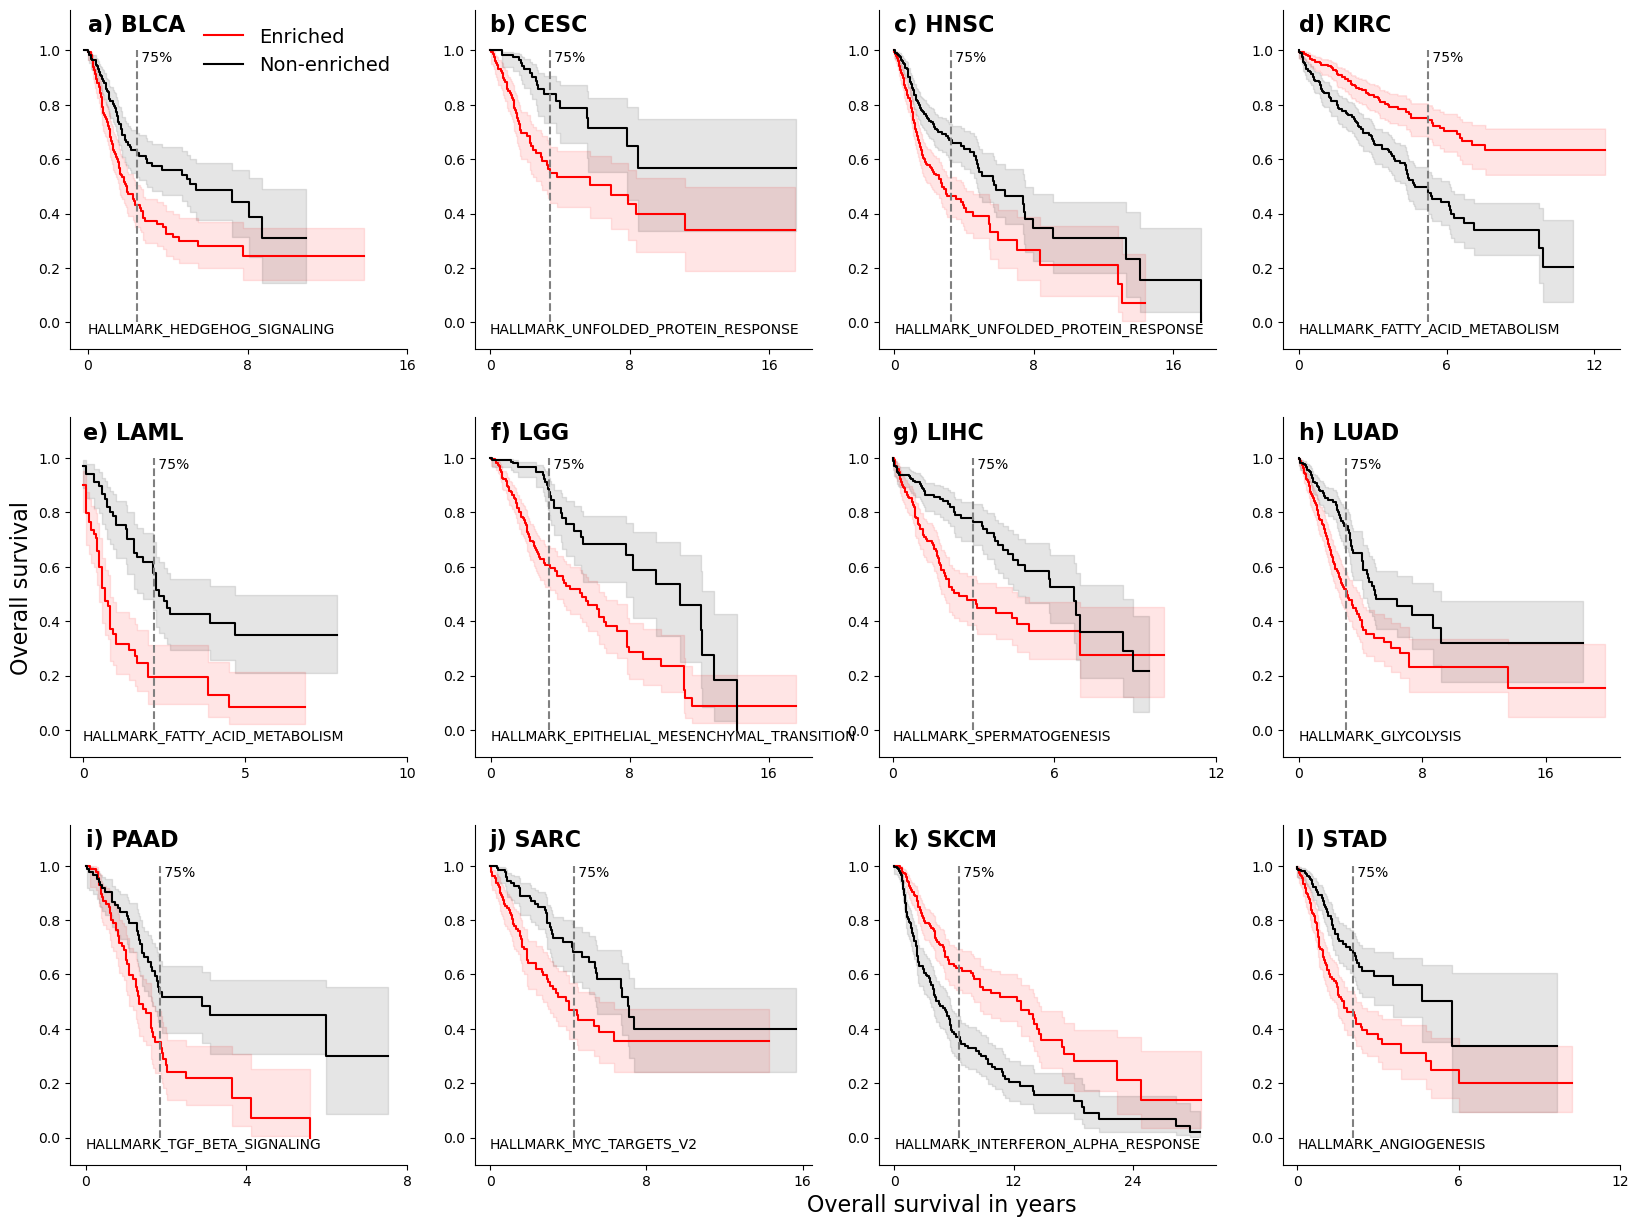

In [7]:
f, ax = plt.subplots(3, 4, figsize=(20,15))

for i, tcga in enumerate(TCGA_DATASETS):
    plot_KM(tcga, tcga_grouped[tcga].sort_values("logrank").index.values[-1], ax=ax[i//4][i%4])

ax[0][0].legend(frameon=False, fontsize=14)

for i, (tcga, letter) in enumerate(zip(TCGA_DATASETS, list("abcdefghijkl"))):

    ax[i//4][i%4].text(
        0, 1.05,f"{letter}) {tcga}", weight="bold", fontsize=16,
        horizontalalignment="left", verticalalignment="bottom"
    )
    ax[i//4][i%4].set_ylim(top=1.15)

    ax[i//4][i%4].set_xlabel("")

ax[1][0].set_ylabel("Overall survival", fontsize=16)
ax[2][1].set_xlabel("                       Overall survival in years", fontsize=16, horizontalalignment="left")

for i, x in enumerate([16, 16, 16, 12, 10, 16, 12, 16, 8, 16, 24, 12]):
    xticks = [0, x//2, x]
    YEARS = 365
    ax[i//4][i%4].set_xticks([k*YEARS for k in xticks], labels=xticks)

f.savefig(f"../figures/_supplementary-KM-plots.pdf", dpi=500, bbox_inches="tight")

## 3 - Appendix: Logrank-RMST comparison

/tmp/ipykernel_502200/1418790433.py:12: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[i//4][i%4].scatter(


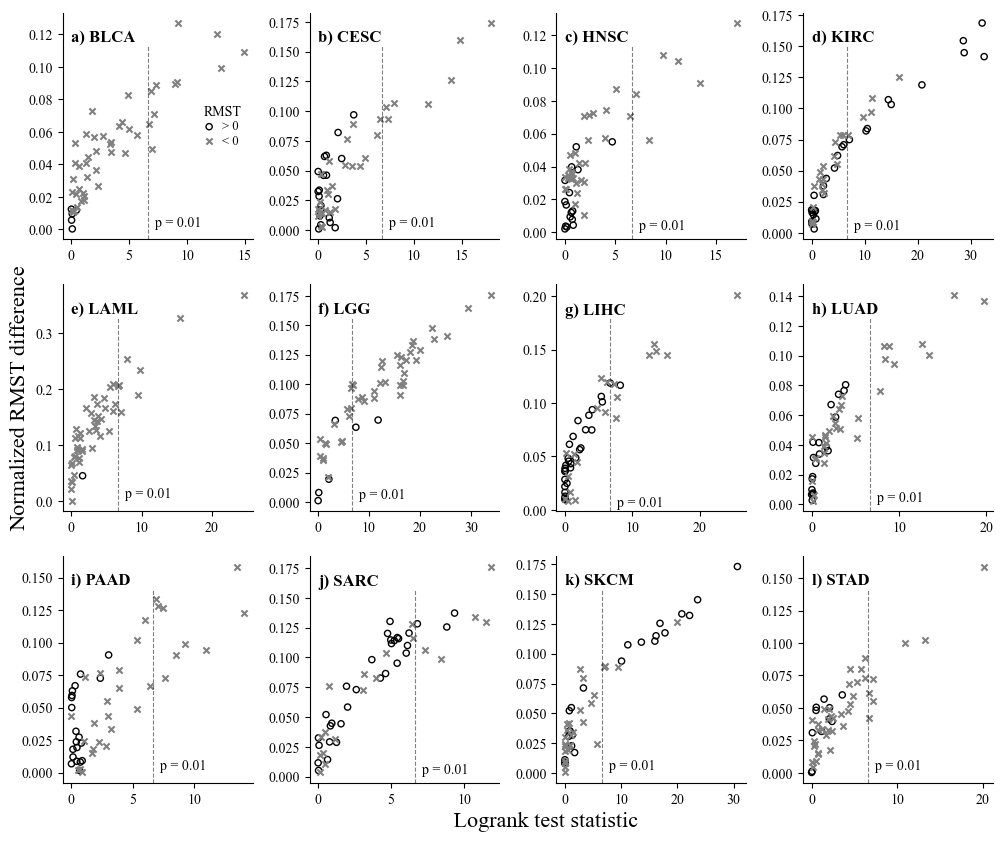

In [8]:
plt.rcParams["font.family"] = "Times New Roman"

f, ax = plt.subplots(3,4, figsize=(12,10), gridspec_kw={"hspace":0.2, "wspace":0.3})

for i, (tcga, letter) in enumerate(zip(TCGA_DATASETS, list("abcdefghijkl"))):
    for positive, marker in zip([True, False], ["o", "x"]):

        ids = np.where((rmst_scores[tcga].values >= 0) == positive)[0].flatten()
        x = logrank_test[tcga].iloc[ids].values
        y = np.abs(rmst_scores[tcga].iloc[ids].values)

        ax[i//4][i%4].scatter(
            x, y,
            s=20, edgecolors="k", facecolor="none" if marker == "o" else "gray",
            marker=marker,
            label=None if i != 0 else ("> 0" if positive else "< 0")
        )

    for loc in ["top", "right"]:
        ax[i//4][i%4].spines[loc].set_visible(False)

    top_ax = ax[i//4][i%4]
    top_xlim = top_ax.get_xlim()
    top_ylim = top_ax.get_ylim()

    top_ax.vlines(6.635, top_ylim[0], top_ylim[1]*0.85, color="k", ls="--", alpha=0.5, lw=0.8)
    top_ax.text(6.635, 0, "  p = 0.01", fontsize=10, horizontalalignment="left", verticalalignment="bottom")

    top_ax.set_ylim(top_ylim)
    top_ax.set_xlim(top_xlim)

    top_ax.text(
        0, top_ylim[1]*0.85, f"{letter}) {tcga}", weight="bold", fontsize=12,
        horizontalalignment="left", verticalalignment="bottom"
    )
    
ax[0][0].legend(fontsize=9, frameon=False, title="RMST", labelspacing=0.2, handlelength=0.5, loc=7)

ax[1][0].set_ylabel("Normalized RMST difference", fontsize=16)
ax[2][1].set_xlabel("         Logrank test statistic", fontsize=16, horizontalalignment="left")

f.savefig("../figures/_supplementary_logrank-rmst-comparison.pdf", dpi=500, bbox_inches="tight")